### import supporting packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from datetime import datetime, timedelta, date
import glob,os
import time
import sys
import warnings
import math
warnings.filterwarnings("ignore")

# prep data 

### acquire proto2 data

In [2]:
path_corrected_proto2='despiked_proto2/'

proto2_corrected_filepaths=[]
for file in sorted(os.listdir(path_corrected_proto2)):
    if file != '.ipynb_checkpoints':
        proto2_corrected_filepaths.append(path_corrected_proto2+file)
    
proto2_corrected_from_files=(pd.read_csv(f,on_bad_lines='skip') for f in proto2_corrected_filepaths)
proto2_corrected=pd.concat(proto2_corrected_from_files)

times=pd.to_datetime(proto2_corrected['Unnamed: 0'],format='%Y-%m-%d %H:%M:%S')
proto2_corrected=proto2_corrected.set_index(times)
proto2_corrected.index.names=['date']
proto2_corrected=proto2_corrected.drop('Unnamed: 0',1)
proto2_corrected;

#take high frequency proto2 data and resample to hourly mean
houravg=proto2_corrected.drop(columns=['datetimestamp']).apply(pd.to_numeric).resample('60min').mean()

### acquire DEC reference data 

In [3]:
#get the epa filenames

path_epa='/data/aq/DEC/csv/'

epa_filepaths=[]
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)
    
epa_from_files=(pd.read_csv(f) for f in epa_filepaths)
epa_df=pd.concat(epa_from_files)
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))

### define some dictionaries that tie the concentration number code to its appropriate name

In [4]:
#set dictionary that matches varid to field name
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}
epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

### toss out times in the DEC observations where there is no recorded data in proto2

In [5]:
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;

### delineate months 

In [6]:
# Select date ranges corresponding to months 
july = (epa_df_matching_proto2['date'] >= '2021-07-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-07-31 23:00:00') 
august = (epa_df_matching_proto2['date'] >= '2021-08-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-08-31 23:00:00') 
september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
october = (epa_df_matching_proto2['date'] >= '2021-10-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-10-31 23:00:00') 
november = (epa_df_matching_proto2['date'] >= '2021-11-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-11-31 23:00:00') 
month_list = [july, august, september, october, november]

# data are ready - begin calibration process 

## ... start by defining functions 

### generate regression coefficients script 

In [7]:
import pandas as pd
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

def generate_coefficients(training_predictors, training_reference_concentrations, method):
    '''
    INPUT...
    training_predictors = dataframe corresponding of predictors in training period 
    training_reference_concentrations = dataframe containing reference concentrations (DEC) during training period
    
    method = 'linear' or 'quadratic' (only LINEAR works as of 02/08/2023)    
    ===========================================================
    RETURNS...
    00 = coefficient + y-intercepts of regression equation as a dictionary (this is what's important!)
    01 = model (kept for documentation purposes)
    '''
    
    if method == 'linear' or method == 'Linear' or method == 'LINEAR':

        #https://www.statology.org/statsmodels-linear-regression-p-value/
        y = training_reference_concentrations
        x = training_predictors
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        analysis = model.summary()
         
        # coefficient dictionary
        coefs=model.params
        coef_dict={}
        # pvalue dictionary
        pvalues=model.pvalues
        pvalue_dict={}
        
        for num_of_predictors in range(len(coefs)):
            if num_of_predictors == 0:
                coef_dict['Y-intercept (constant term)']=coefs[num_of_predictors]
                pvalue_dict['Y-intercept (constant term)']=pvalues[num_of_predictors]

            else:
                coef_dict[training_predictors.columns[num_of_predictors-1]]=coefs[num_of_predictors]
                pvalue_dict[training_predictors.columns[num_of_predictors-1]]=pvalues[num_of_predictors]
        
        output = {'coef_dict':coef_dict,'pvalue_dict':pvalue_dict,'analysis':analysis,'model':model}
    
        return output

In [8]:
def generate_coefficients_optimize_bypvalue(training_predictors, testing_predictors, testing_reference_concentrations):
    ''' *** UNFINISHED 
    INPUT...
    training_predictors = dataframe of training period predictors 
    testing_predictors = dataframe of testing period predictors 
    testing_reference_concentrations = 
    
    ===========================================================
    RETURNS...
    calibrated_data = pandas series that contains date (x) and calibrated data (y)
    '''
    coefficients = generate_coefficients(training_predictors,training_reference_concentrations,'linear') # initial regression with all coefficients 
    
    for predictor in range(len(training_predictors.columns)):
        for key,value in coefficients['pvalue_dict'].items():
            if value > 0.05 and key != 'Y-intercept (constant term)':
                print('Removing predictor...',key,' with p-value', str(round(value,2)))
                training_predictors = training_predictors.drop(columns=[str(key)])
                testing_predictors = testing_predictors.drop(columns=[str(key)])

            coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')
            
    return coefficients['coef_dict']

In [9]:
def calibrate(coef_dict, testing_predictors):
    '''
    INPUT...
    coef_dict = dictionary of regression coefficients generated using the generate_coefficients script 
    testing_data_input = dataframe containing testing concentrations, must include IDENTICAL column names as the training data
    input from the generate_coefficients script to work properly 
    
    ===========================================================
    RETURNS...
    calibrated_data = pandas series that contains date (x) and calibrated data (y)
    '''
        
    calibrated_data = coef_dict['Y-intercept (constant term)']
    print('Beginning calibration... starting with y-intercept = ', calibrated_data)

    for key,value in coef_dict.items():
        if key != 'Y-intercept (constant term)':
            print('Calibrating with coefficient...', coef_dict[key], 'for variable', key)
            calibrated_data += coef_dict[key]*testing_predictors[key]
            print('Coefficient done')
    print('Calibration completed!')
            
    return calibrated_data

## apply functions to prepped data 

CO ... training period =  July
Removing predictors with p-value < 0.05
Removing predictor... Temp²  with p-value 0.28
Beginning calibration... starting with y-intercept =  -249.5644999172113
Calibrating with coefficient... 11.945825665337875 for variable Temp
Coefficient done
Calibrating with coefficient... 4.011293489452489 for variable RH
Coefficient done
Calibrating with coefficient... -0.18702409699189956 for variable T*RH
Coefficient done
Calibrating with coefficient... -17.20437532102599 for variable T*ΔVolt
Coefficient done
Calibrating with coefficient... 2644.721904616654 for variable ΔVolt
Coefficient done
Calibrating with coefficient... 9.054179525259178 for variable Weekday Binary
Coefficient done
Calibration completed!
Plotting for  CO


CO ... training period =  August
Removing predictors with p-value < 0.05
Removing predictor... Temp  with p-value 0.23
Removing predictor... Temp²  with p-value 0.43
Removing predictor... T*RH  with p-value 0.26
Beginning calibration... sta

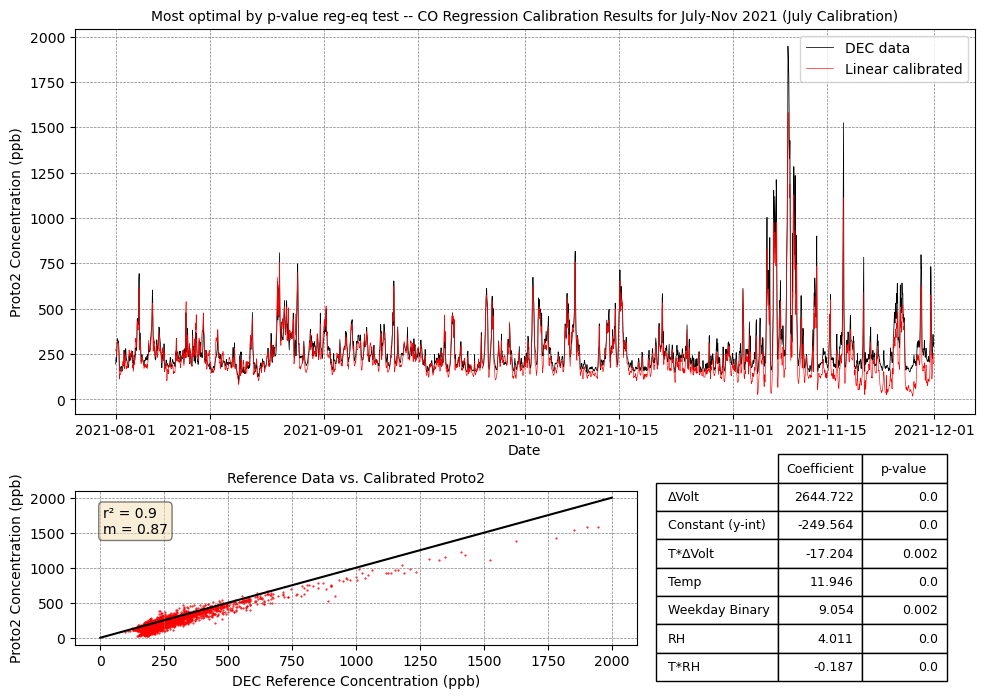

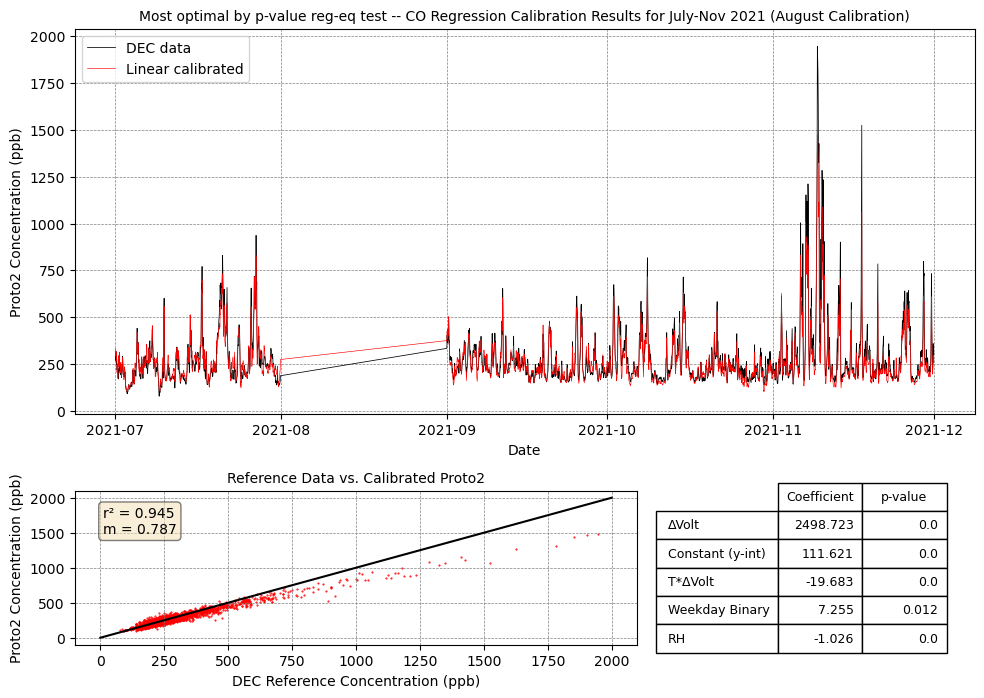

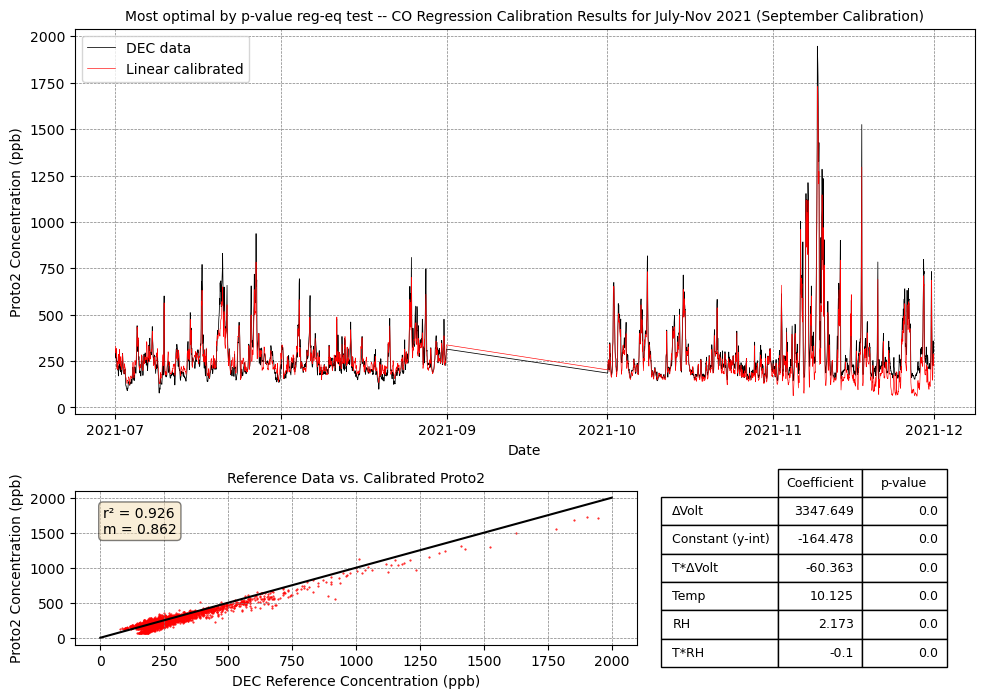

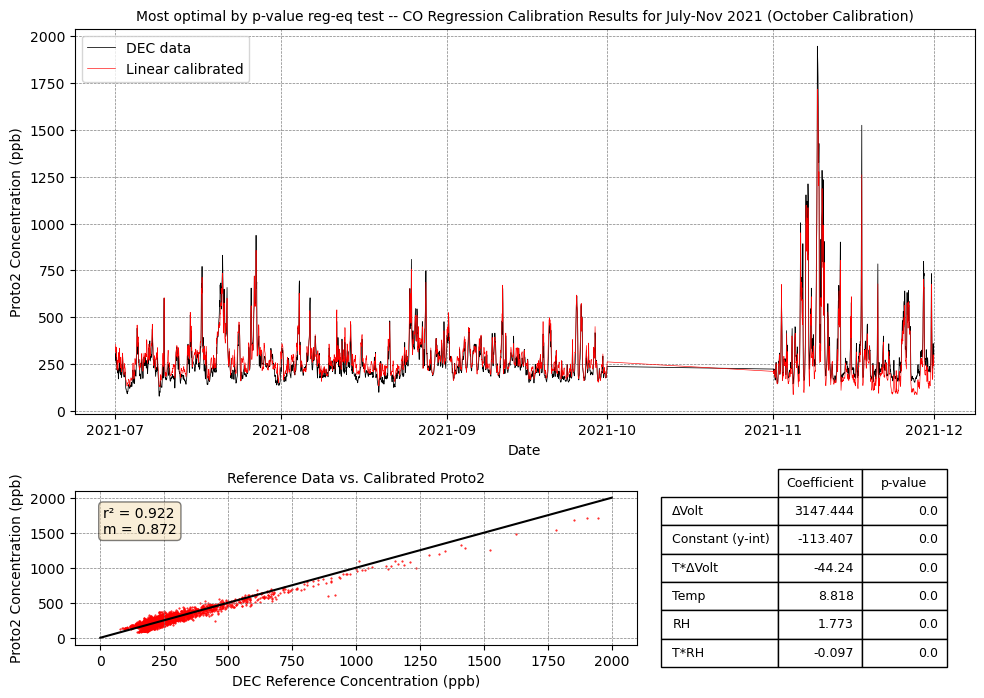

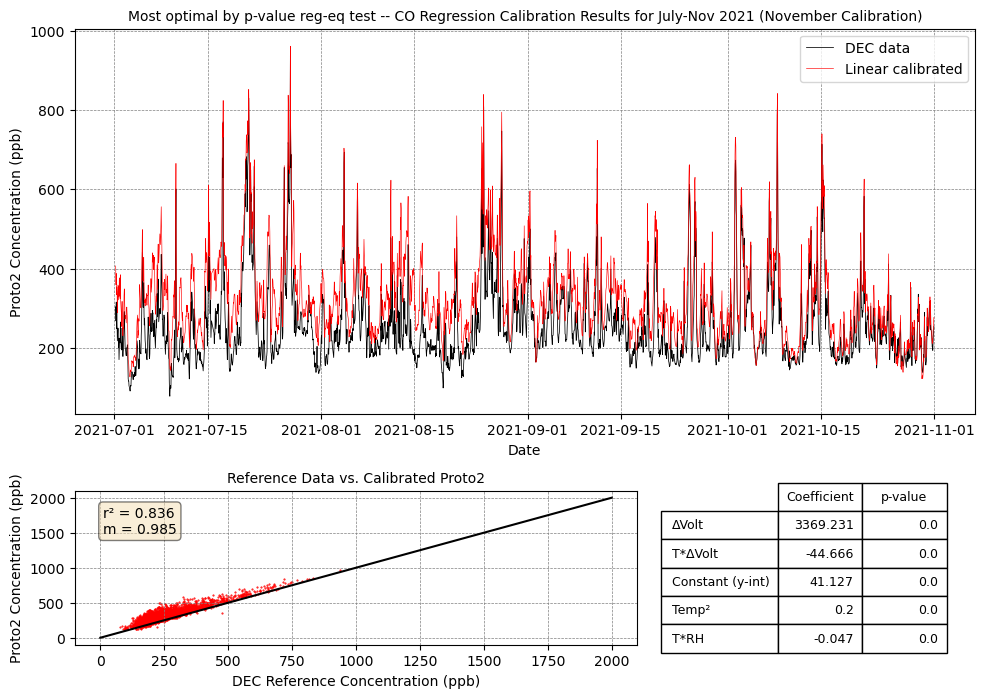

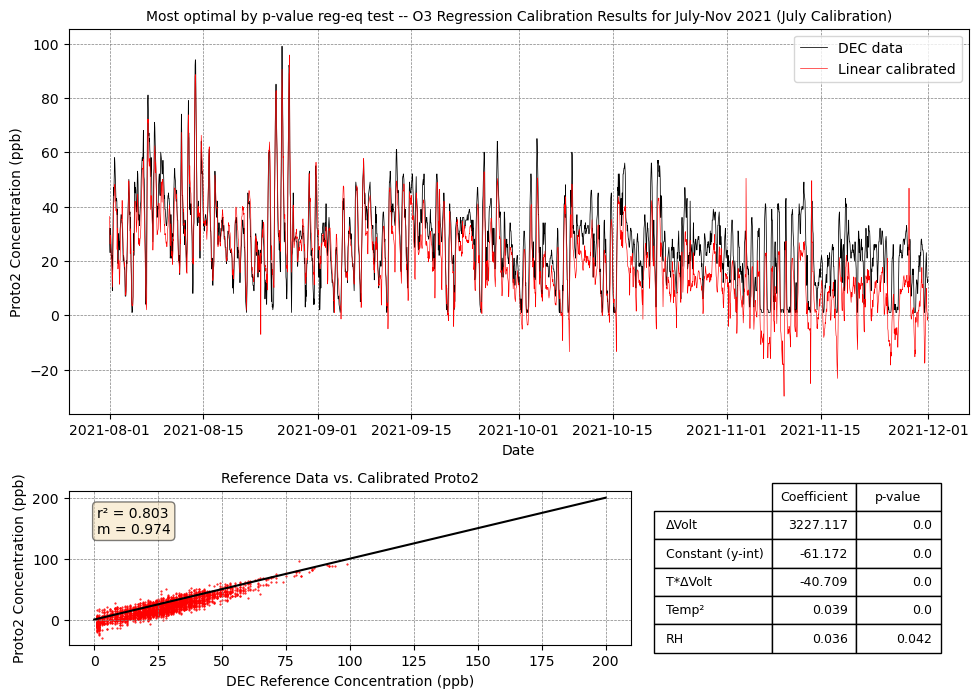

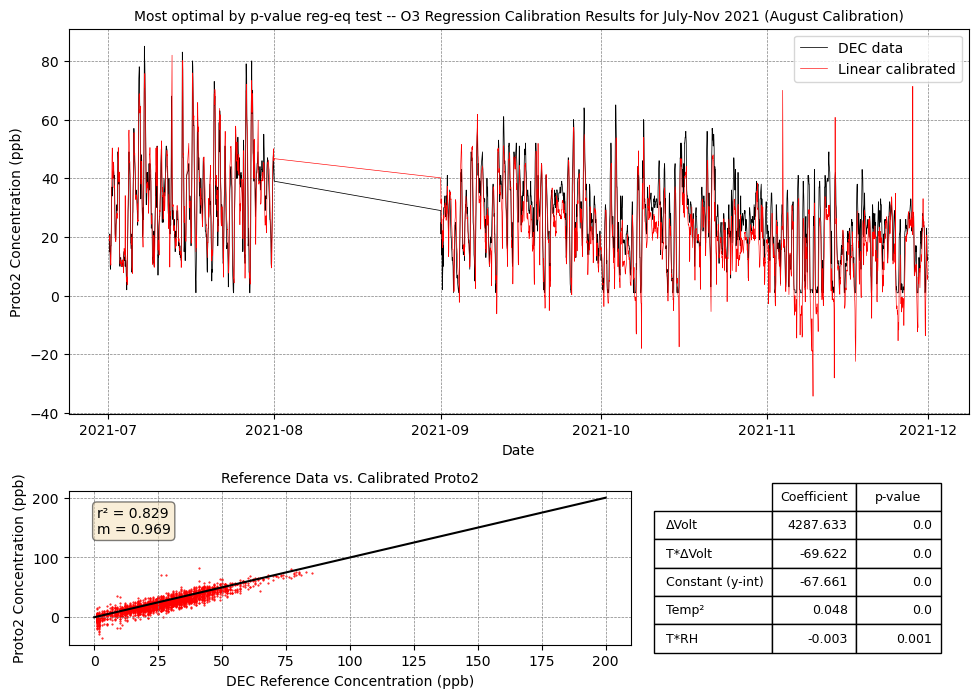

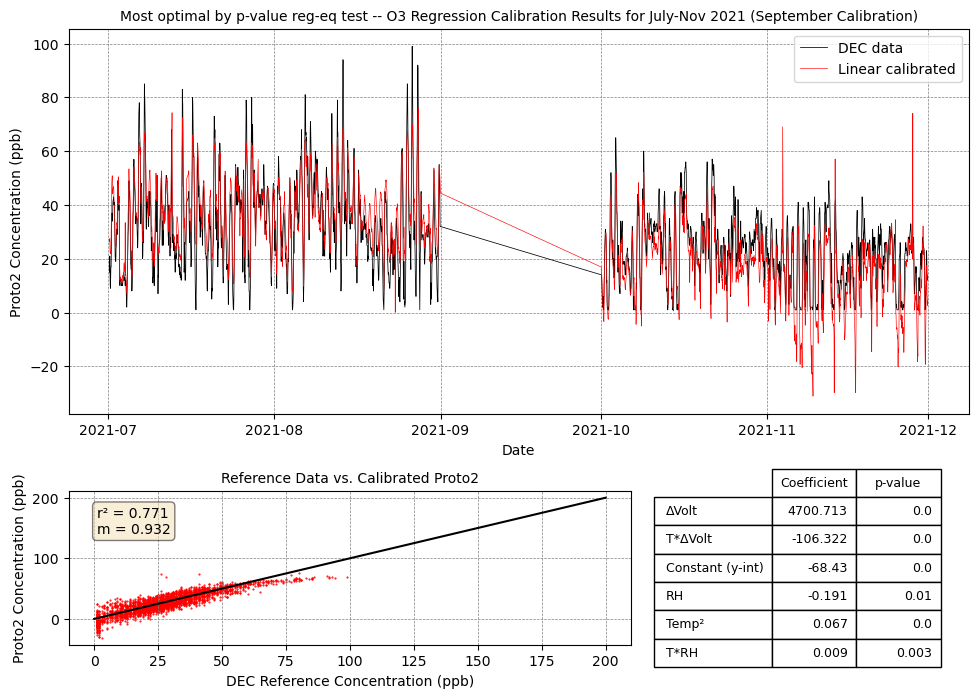

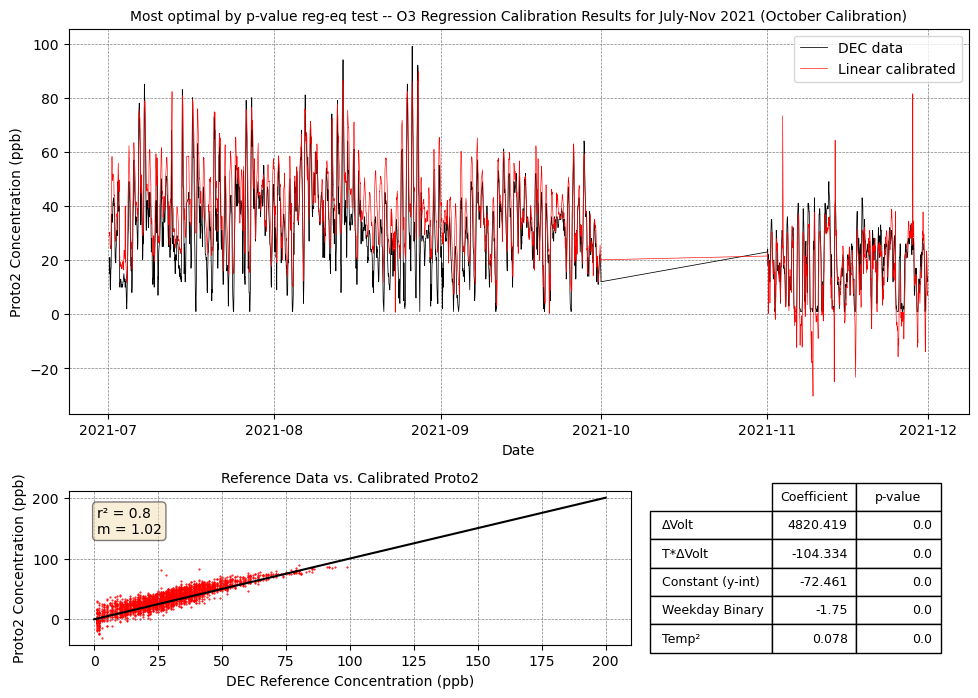

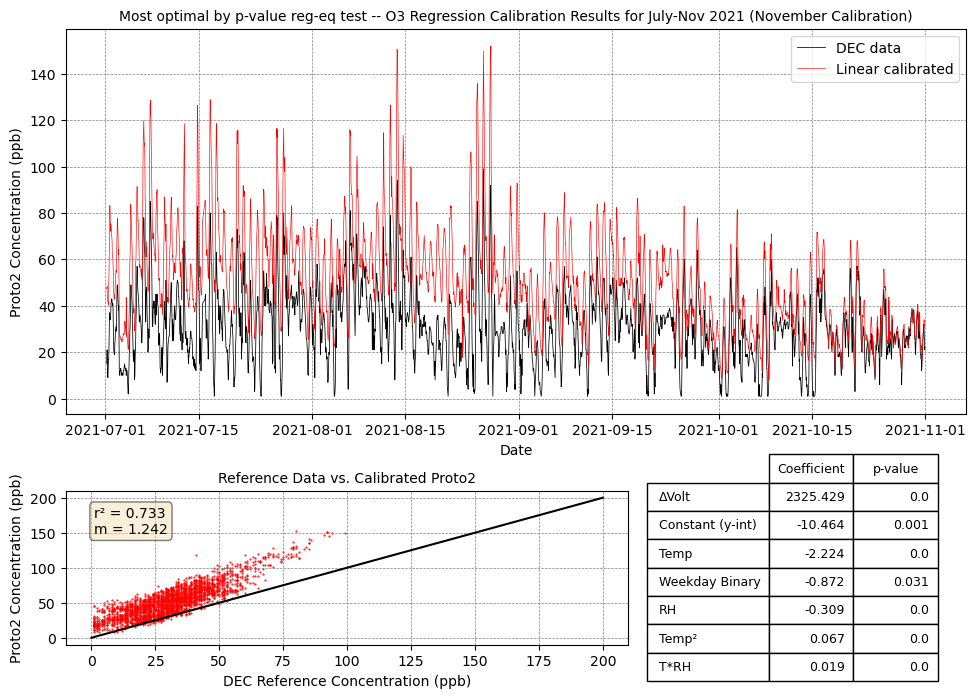

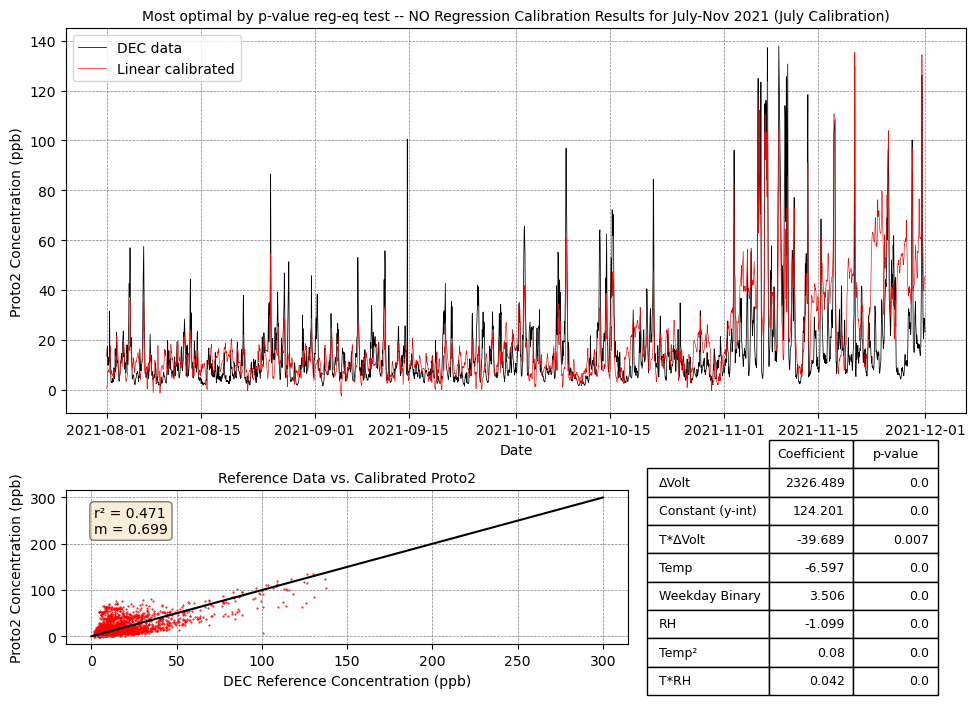

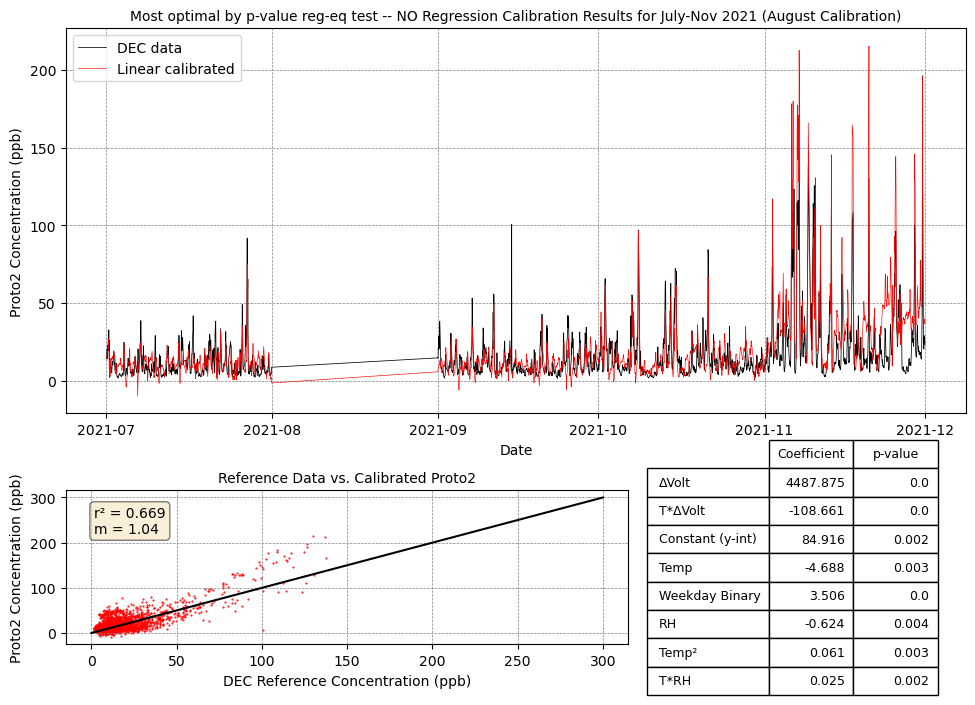

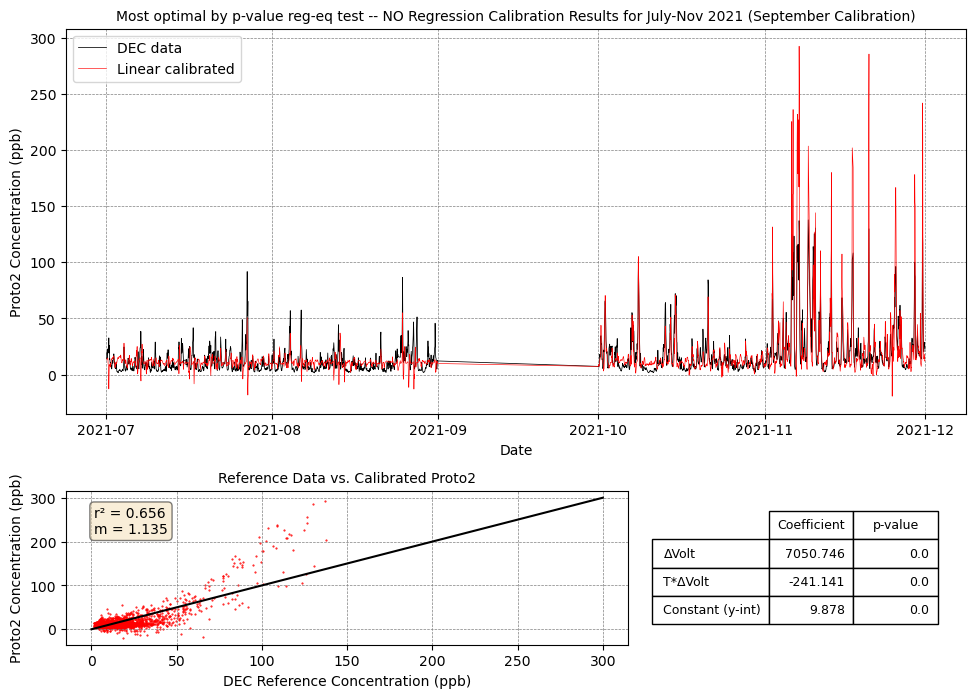

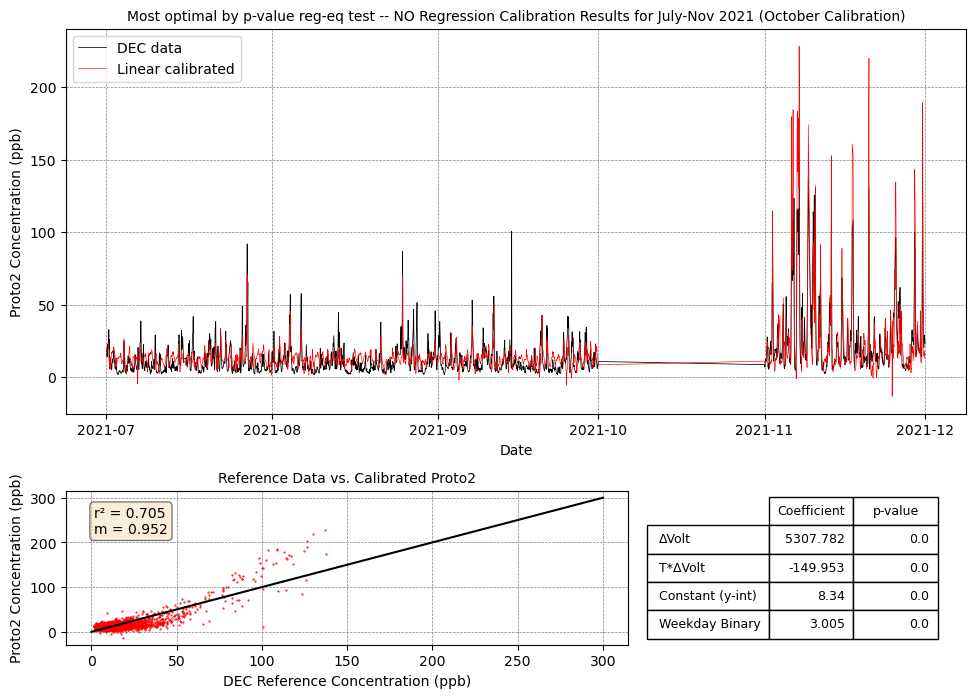

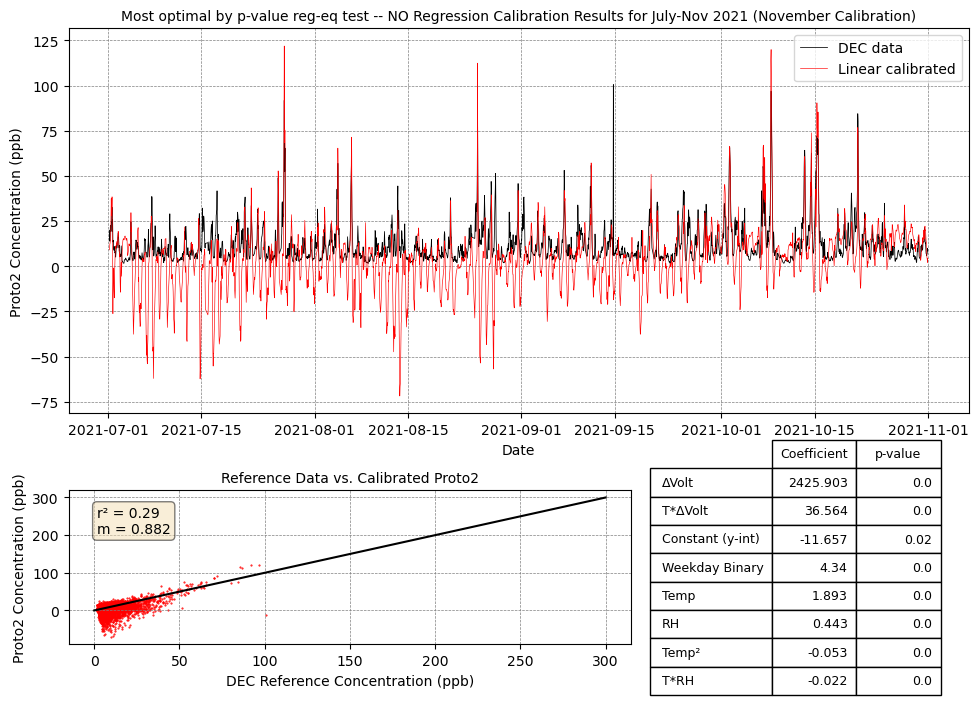

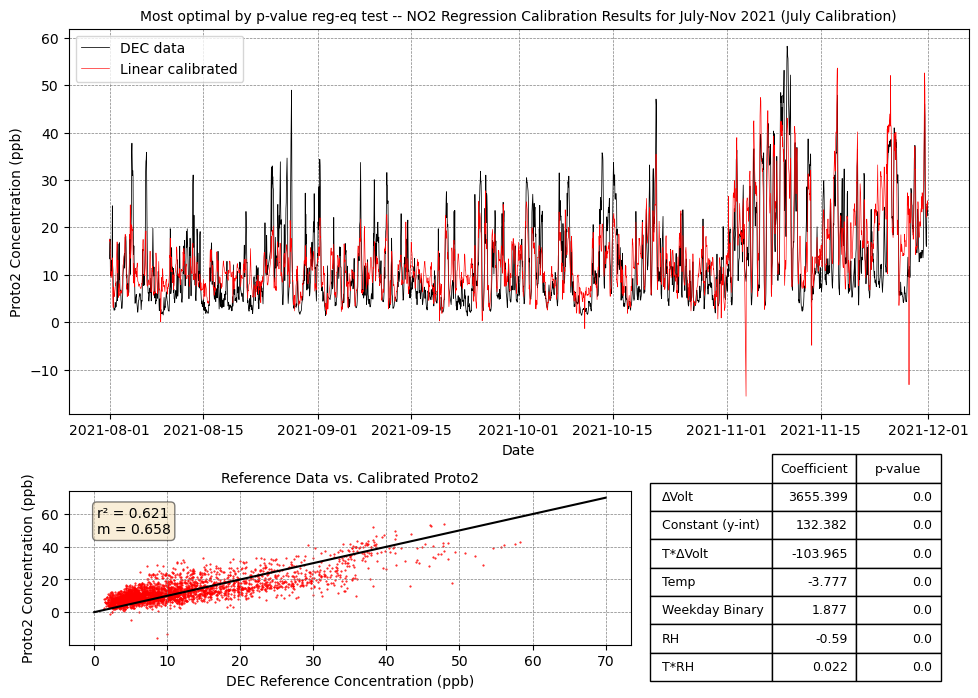

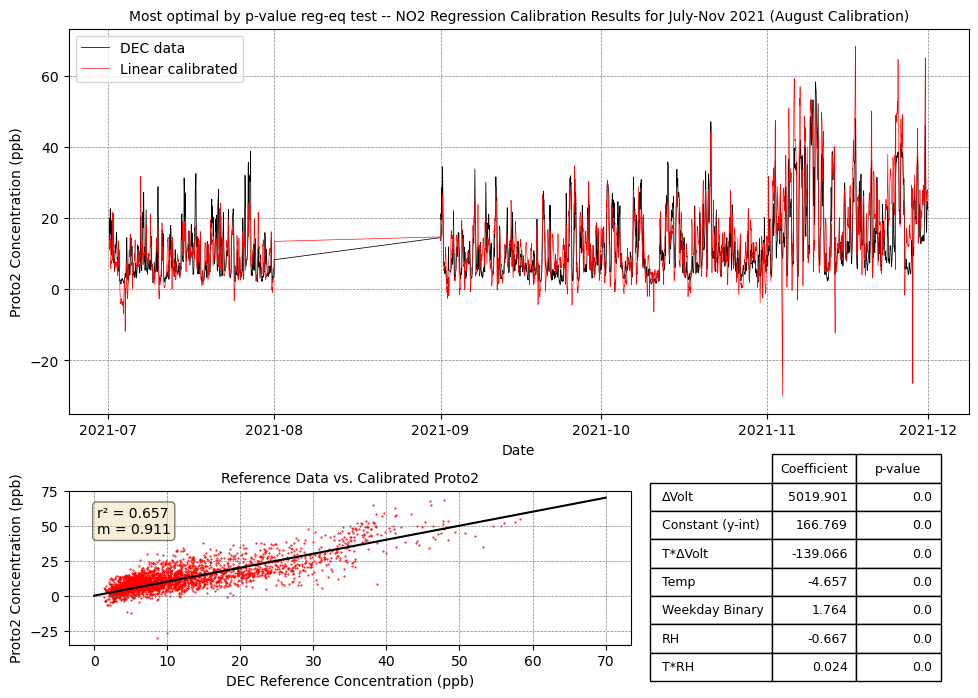

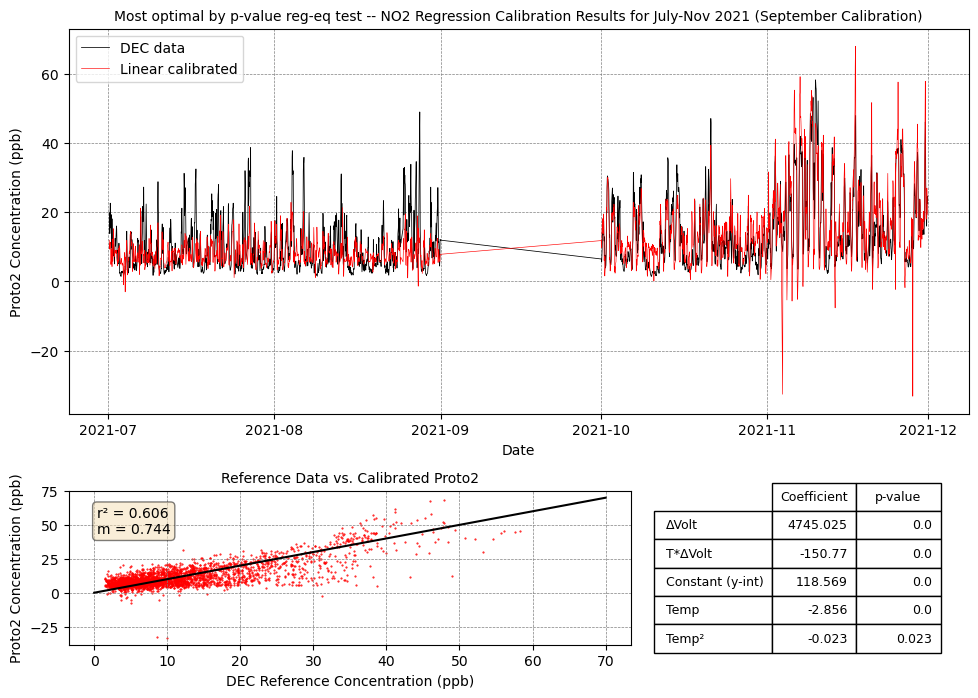

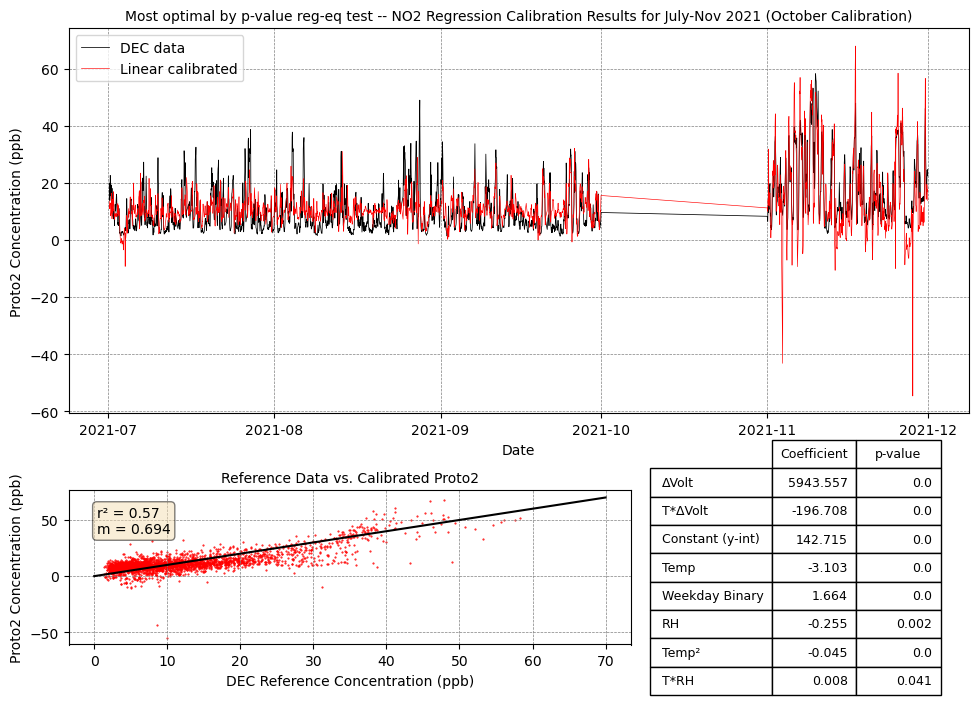

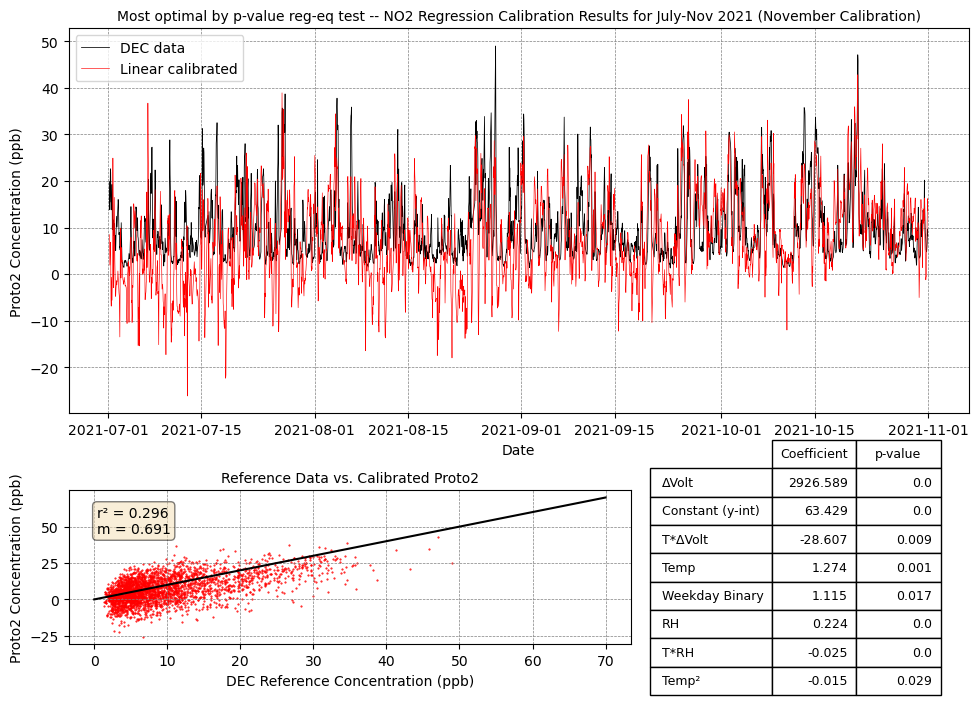

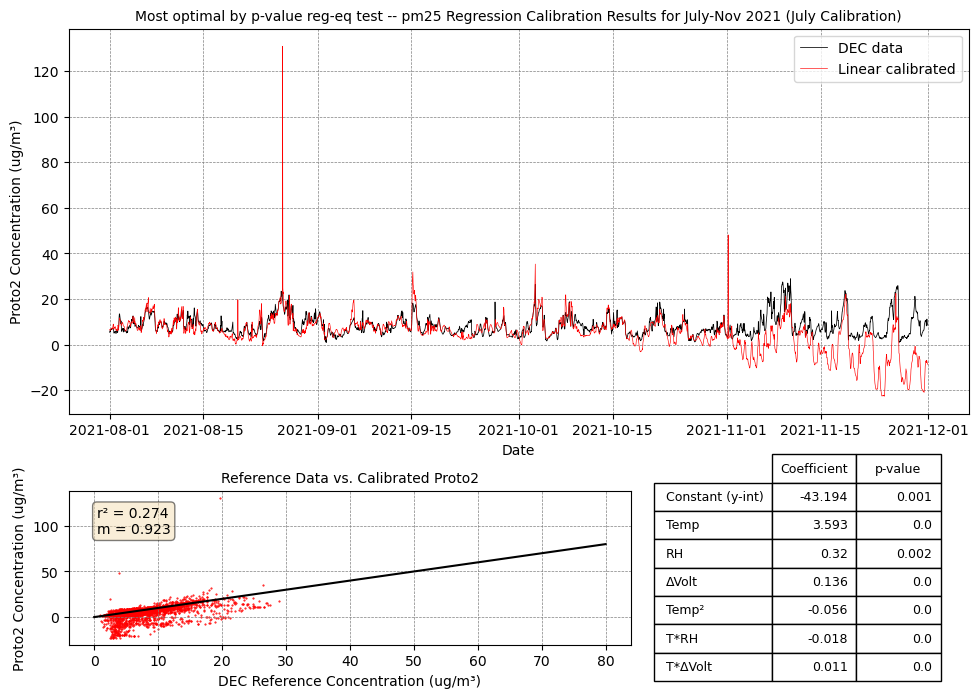

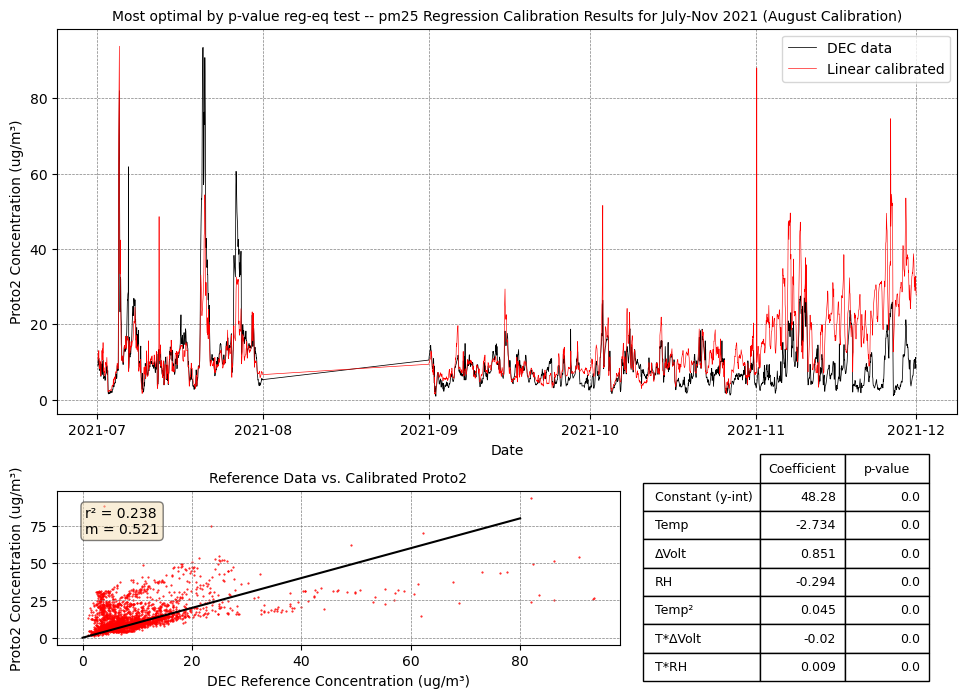

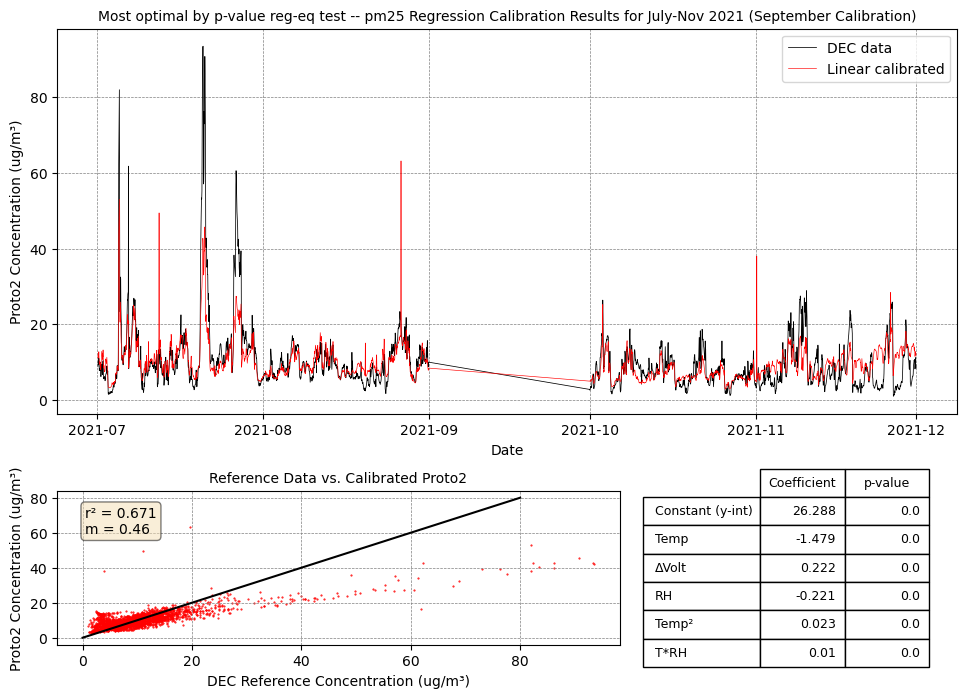

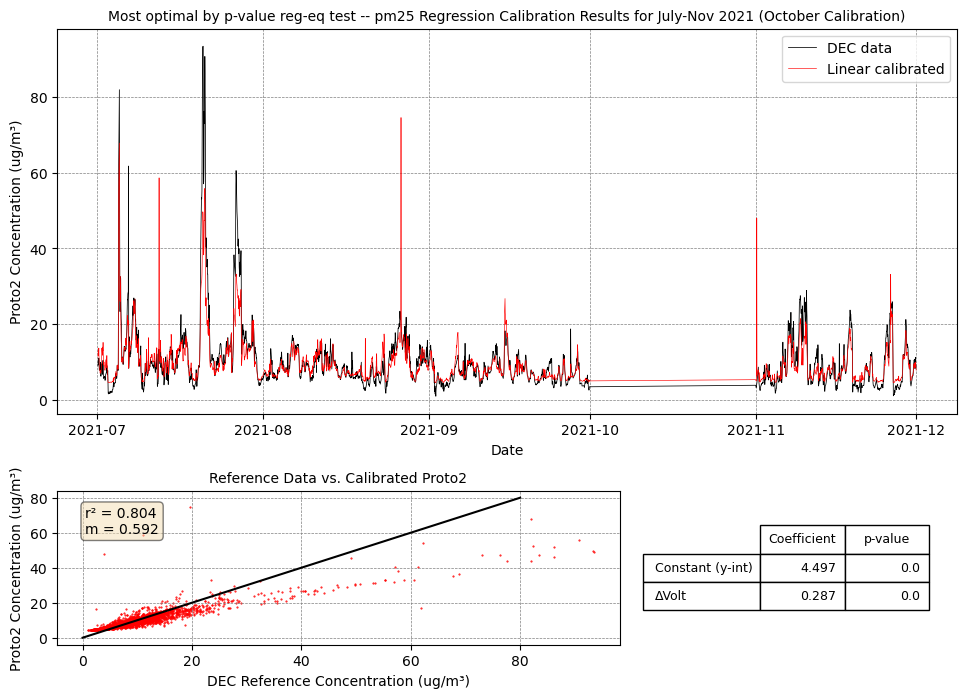

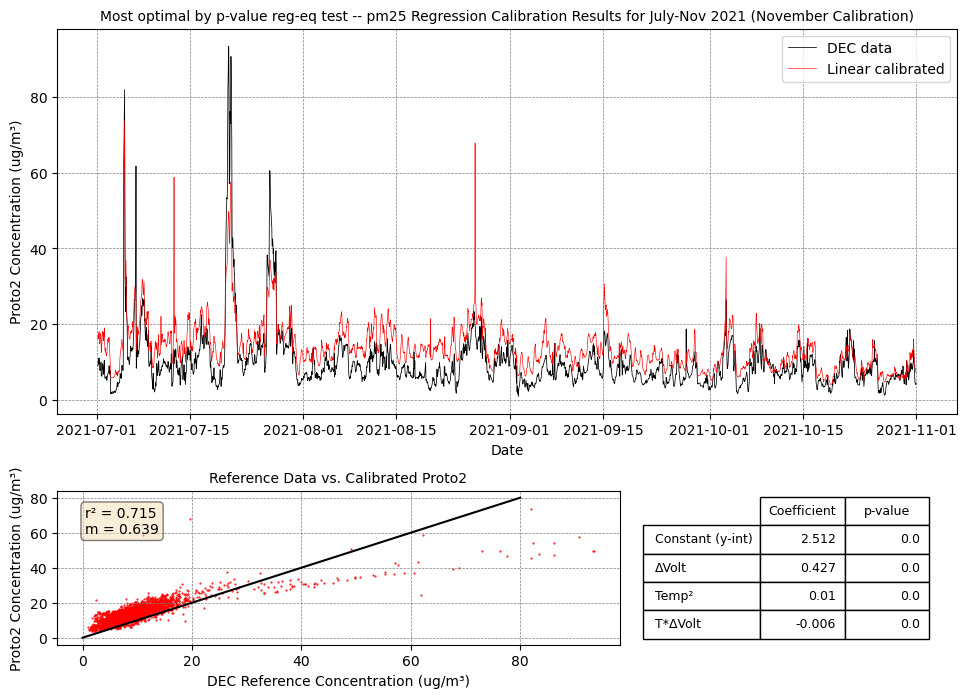

In [10]:
#the observed concentrations and proto2 data are using different timezones. apply a 5 hour fix to shift them over
#long term it may be wise to just correct proto2 data and rewrite it as a file
tshift=5

#specify the method you want for the regression
method='linear'

#define an empty dictionary to hold output
training_periods = [7,8,9,10,11]

'''Creating model performance stats dictionaries and dataframes '''
from sklearn.metrics import mean_squared_error

model_stats=['r²','Slope (m)','RMSE','Percent Bias','Training Period']

CO_stats_df = pd.DataFrame(columns=model_stats)
O3_stats_df = pd.DataFrame(columns=model_stats)
NO_stats_df = pd.DataFrame(columns=model_stats)
NO2_stats_df = pd.DataFrame(columns=model_stats)
pm25_stats_df = pd.DataFrame(columns=model_stats)
pollutant_stats_df_dict = {42101:CO_stats_df,44201:O3_stats_df,42601:NO_stats_df,42602:NO2_stats_df,88101:pm25_stats_df}

#txtname = 'pvalueopt_r2_slope_rmse_percentbias_coefficients_list.txt'
#coefficients_file = open('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+txtname, 'w')
#coefficients_file.write('Model performance when data are trained for one month and tested against the remaining months. Only coefficients with p values < 0.05 retained. \n Script used: monthly_reg_plots.ipynb \n')
#coefficients_file.write('\n')

    
# CO:42101  O3NO2:44201  NO:42601  NO2:42602 PM2.5:88101
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:
    if var_id==44201:
        gname='O3'
    elif var_id in [88101]:
        gname='pm25'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]

    #coefficients_file = open('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+txtname, 'a')
    #coefficients_file.write(gname+ ' \n')

    for training_month in training_periods:


        #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
        if var_id==44201:
            epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
            epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)

        else:
            epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
            epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)


        #combine the observations and proto2 data into one dataset
        combined_df=pd.concat([epa_concentration_field,houravg],axis=1).dropna()

        #include some checks to see if the field is O3 or pm2.5
        #O3 needs to subtract NO2 because the sensor only records O3NO2
        #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
        #basically we're just calculating the voltage difference here
        if var_id==44201:
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
            gname='O3'
            unit = '_ppb'
            pltunit = 'ppb'

        elif var_id in [88101]:
            gname='pm25'
            combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
            unit='_env_ugm3'
            pltunit = 'ug/m³'

        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

            combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
            unit = '_ppb'
            pltunit = 'ppb'


        #perform some additional last minute qc on the data
        #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
        combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                             & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                             & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]

        # some fun time predictors 
        combined_df_filtered['decimal_day'] = combined_df_filtered.index.dayofyear # create a column for decimal day; aka time predictor 

        combined_df_filtered['dayofweek'] = combined_df_filtered.index.dayofweek # creates column of weekday numbers 
        combined_df_filtered.loc[combined_df_filtered['dayofweek'] <= 4, 'weekday_binary'] = 1 # converts weekdays to 0 (if Zamora, now 1) 
        combined_df_filtered.loc[combined_df_filtered['dayofweek'] > 4, 'weekday_binary'] = 0 # converts weekends to 1 (if Zamora, now 0) 

        daylight_mask = (combined_df_filtered.index >= '06:00:00') & (combined_df_filtered.index  <= '23:00:00') # delinate daytime
        combined_df_filtered.loc[daylight_mask, 'daylight_hours_binary'] = 1 # converts daytime to 1
        combined_df_filtered['daylight_hours_binary'] = combined_df_filtered['daylight_hours_binary'].fillna(0) # nighttime is 0

        # delineate training and test periods 
        #combined_df_filtered_training=combined_df_filtered.loc[september]
        training_period_df = combined_df_filtered.loc[combined_df_filtered.index.month == training_month]
        
        #combined_df_filtered_testing=combined_df_filtered.loc[july+august+october+november]
        testing_period_df = combined_df_filtered.loc[combined_df_filtered.index.month != training_month] # removes training period from testing period 


        ## training fields using proto2_QC.csv 
        training_reference_concentrations = training_period_df['value']
        training_data = [training_period_df['temp_sht31_degC'], # T
                         training_period_df['temp_sht31_degC']**2, # T^2
                         training_period_df['rh_sht31_percent'], # RH
                         training_period_df['temp_sht31_degC']*training_period_df['rh_sht31_percent'], # T-RH interaction
                         training_period_df['temp_sht31_degC']*training_period_df[gname+'_voltdiff'], # T-sensor interaction
                         training_period_df[gname+'_voltdiff'], # sensor
                         training_period_df['weekday_binary']] # binary weekend
                         #combined_df_filtered_training['decimal_day']] # decimal day

        training_data_input = pd.DataFrame(training_data, index=['Temp','Temp²','RH','T*RH','T*ΔVolt','ΔVolt','Weekday Binary']).transpose()


        # testing fields using proto2_QC.csv 
        testing_reference_concentrations = testing_period_df['value']
        testing_data = [testing_period_df['temp_sht31_degC'], # T
                        testing_period_df['temp_sht31_degC']**2, # T^2
                        testing_period_df['rh_sht31_percent'], # RH
                        testing_period_df['temp_sht31_degC']*testing_period_df['rh_sht31_percent'], # T-RH interaction
                        testing_period_df['temp_sht31_degC']*testing_period_df[gname+'_voltdiff'], # T-sensor interaction
                        testing_period_df[gname+'_voltdiff'], # sensor
                        testing_period_df['weekday_binary']] # binary weekend
                        #combined_df_filtered_testing['decimal_day']] # decimal day

        testing_data_input = pd.DataFrame(testing_data, index=['Temp','Temp²','RH','T*RH','T*ΔVolt','ΔVolt','Weekday Binary']).transpose()
        
        training_period_month = str(pd.DatetimeIndex(training_period_df.index).month_name()[1])
        testing_period = testing_reference_concentrations.index
        print(gname, '... training period = ',training_period_month)

        coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')
        print('Removing predictors with p-value < 0.05')
        for predictor in range(len(training_data_input.columns)):
            for key,value in coefficients['pvalue_dict'].items():
                if value > 0.05 and key != 'Y-intercept (constant term)':
                    print('Removing predictor...',key,' with p-value', str(round(value,2)))
                    training_data_input = training_data_input.drop(columns=[str(key)])
                    testing_data_input = testing_data_input.drop(columns=[str(key)])

            coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')    

        calibrated_data = calibrate(coefficients['coef_dict'], testing_data_input)

        model = gname+'_model'
        model_name = gname+'_model'

        ''' model performance '''
        m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
        #r2 = (sm.OLS(testing_reference_concentrations, calibrated_data).fit()).rsquared
        n=len(testing_reference_concentrations)
        r2=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
        #rmse = math.sqrt(sm.OLS(testing_reference_concentrations, calibrated_data).fit().mse_total)
        rmse =  math.sqrt(mean_squared_error(calibrated_data, testing_reference_concentrations))
        percent_bias = ((testing_reference_concentrations.mean()-calibrated_data.mean())/(abs(testing_reference_concentrations.mean())))*100
        pollutant_stats_df_dict[var_id] = pollutant_stats_df_dict[var_id].append({'r²':r2,'Slope (m)':m[0],'RMSE':rmse,'Percent Bias':percent_bias,
                                                                                  'Training Period':training_period_month}, ignore_index=True)
        ''' PLOT TIME :) '''
        print('Plotting for ',gname)

        fig = plt.subplots(figsize=(10,8))
    
        
        ''' DEC vs. Calibrated time series plot (top) '''
        time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
        time_series.set_title('time_series')
        time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
        time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.55)
        time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.45)
        time_series.legend()  
        time_series.set_title('Most optimal by p-value reg-eq test -- '+gname+' Regression Calibration Results for July-Nov 2021 ('+training_period_month+' Calibration)', fontsize=10)
        time_series.set_xlabel('Date')
        time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 

        ''' uncomment to get specific date windows '''
        #time_series.set_xlim([date(2021,7,1), date(2021,7,31)])
        #time_series.set_xlim([date(2021,8,1), date(2021,8,31)])
        #time_series.set_xlim([date(2021,9,1), date(2021,9,30)])
        #time_series.set_xlim([date(2021,10,1), date(2021,10,31)])
        #time_series.set_xlim([date(2021,11,1), date(2021,11,30)])
        #time_series.set_xlim([date(2021,11,21), date(2021,11,30)])
        #time_series.set_xlim([date(2021,7,1), date(2021,7,7)])

        ''' DEC vs. Calibrated trend  plot (bottom left) '''
        data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
        data_series.set_title('data_series')
        data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
        # 1:1 line
        if var_id==42101: # CO
            xmax = 2000
        if var_id==44201: # O3
            xmax = 200
        if var_id==42601: # NO
            xmax = 300
        if var_id==42602: # N02
            xmax = 70
        if var_id==88101: # pm25
            xmax = 80 
        ymax=xmax
        point1 = [0,0]
        point2 = [xmax,ymax]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        data_series.plot(x_values, y_values, color='black', label='1:1 Line')
        # plotting data... 
        data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
        data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
        data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
        data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
        data_series.text(0.05, 0.90, 'r² = '+str(r2.round(3))+'\nm = '+str(m[0].round(3)), 
                         transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ''' Regression Coefficient Table (bottom right) '''
        table_data = pd.DataFrame()
        table_data = table_data.append([coefficients['coef_dict'], coefficients['pvalue_dict']],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                      index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
        table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
        table = plt.subplot2grid((3, 3), (2, 2))
        #table.text(-0.0912,0.07,'Regression Coefficients Table')
        #hide the axes
        table.patch.set_visible(False)
        table.axis('off')
        table.axis('tight')
        regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
        regression_table.scale(0.75,2)
        regression_table.set_fontsize(15)

        plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
        #print('===')
        #print('Uncalibrated r² = ', coefficients['model'].rsquared.round(2))
        #print('Calibration r²  = ', r2.round(2))
        figname = str(gname+'_'+training_period_month+'_pvalue-opt')

        '''
        print('Saving figure as...',figname)
        filepath = '/data/shared/ehojeily/pvalue_optimization_plots/all_months_calibration/'
        plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
        '''
        '''
        with open(filepath+'readme.txt', 'w') as f:
            f.write('Proto2 calibration analysis plots using generate_coefficients and calibrate function. All months used as training periods \n Script used: new_monthly_reg.ipynb')
        '''
        '''
        
        txtname = 'pvalueopt_r2_slope_rmse_percentbias_coefficients_list.txt'
        #plt.savefig('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+figname+'.png',bbox_inches='tight',dpi=300)
        coefficients_file = open('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+txtname, 'a')
        coefficients_file.write(gname+' training period = '+training_period_month+'\n    coefficients = '+str(testing_data_input.columns.tolist())+'\n')
        coefficients_file.write(' training period = '+training_period_month+'\n    coefficients = '+str(testing_data_input.columns.tolist())+'\n')
        '''
        print('\n')
        #plt.close()

#coefficients_file.close()

### create quadplots 

In [ ]:
pollutant_stats_df_dict

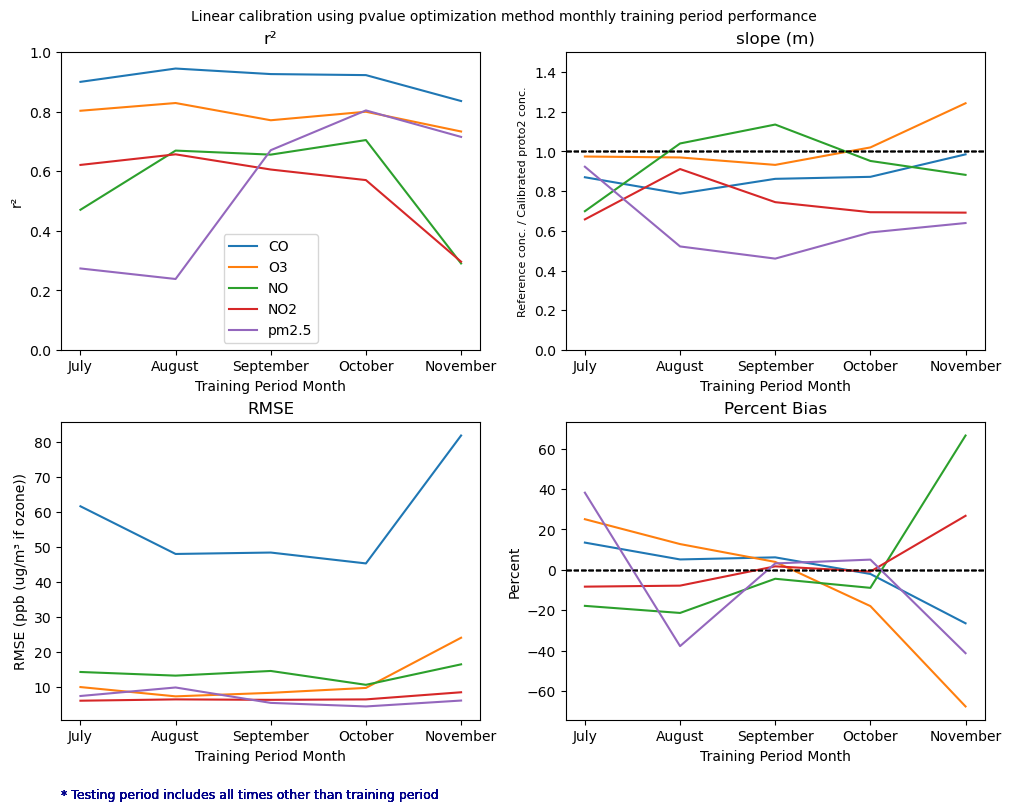

In [18]:
''' Monthly stat breakdown '''
fig = plt.subplots(figsize=(10,8), layout='constrained')
plt.suptitle('Linear calibration using pvalue optimization method monthly training period performance ', fontsize=10)

r2_analysis = plt.subplot2grid((2, 2), (0, 0))
m_analysis = plt.subplot2grid((2, 2), (0, 1))
rmse_analysis = plt.subplot2grid((2, 2), (1, 0))
percentbias_analysis = plt.subplot2grid((2, 2), (1, 1))


var_id_2_name={42101:'CO',44201:'O3',42601:'NO',42602:'NO2',88101:'pm2.5'}
for var_id in [42101, 44201, 42601, 42602, 88101]:
    if var_id in [88101]:
        pltunit = 'ug/m³'
    else:
        pltunit = 'ppb'
            
    r2_analysis.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['r²'], label=var_id_2_name[var_id])
    r2_analysis.set_ylim(0,1)
    r2_analysis.set_title('r²')
    r2_analysis.set_xlabel('Training Period Month')
    r2_analysis.set_ylabel('r²')
    r2_analysis.legend()

    
    m_analysis.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['Slope (m)'], label=var_id_2_name[var_id])
    m_analysis.axhline(y = 1, color = 'black', linestyle = '--', linewidth=1) # indicate slope of 1 / 1:1 line
    m_analysis.set_ylim(0,1.5)
    m_analysis.set_title('slope (m)')
    m_analysis.set_xlabel('Training Period Month')
    m_analysis.set_ylabel('Reference conc. / Calibrated proto2 conc.', fontsize = 8)


    
    rmse_analysis.set_title('RMSE')
    rmse_analysis.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['RMSE'], label=var_id_2_name[var_id])
    #rmse_analysis.legend(loc='upper center', bbox_to_anchor=(0,-0.15),
              #ncol=2, fancybox=True, shadow=True)
    rmse_analysis.set_xlabel('Training Period Month')
    rmse_analysis.set_ylabel('RMSE (ppb (ug/m³ if ozone))')
    rmse_analysis.text(0.45,-0.25, '* Testing period includes all times other than training period', horizontalalignment='center',
             verticalalignment='center', transform=rmse_analysis.transAxes, color='darkblue', fontsize=9) 

    
    percentbias_analysis.set_title('Percent Bias')
    percentbias_analysis.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['Percent Bias'], label=var_id_2_name[var_id])
    percentbias_analysis.axhline(y = 0, color = 'black', linestyle = '--', linewidth=1) # indicate slope of 1 / 1:1 line
    percentbias_analysis.set_xlabel('Training Period Month')
    percentbias_analysis.set_ylabel('Percent')
    

figname = 'pvalueopt_r2_slope_rmse_percentbias'
plt.savefig('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+figname+'.png',bbox_inches='tight',dpi=300)
#with open('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+figname+'_readme.txt', 'w') as f:
    #f.write('Model performance when data are trainined for one month and tested against the remaining months. \n Script used: monthly_reg_plots.ipynb')


#### 

In [11]:
#the observed concentrations and proto2 data are using different timezones. apply a 5 hour fix to shift them over
#long term it may be wise to just correct proto2 data and rewrite it as a file
tshift=5

#specify the method you want for the regression
method='linear'

#define an empty dictionary to hold output
training_periods = [7,8,9,10,11]

'''Creating model performance stats dictionaries and dataframes '''
from sklearn.metrics import mean_squared_error

model_stats=['r²','Slope (m)','RMSE','Percent Bias','Training Period']

CO_stats_df2 = pd.DataFrame(columns=model_stats)
O3_stats_df2 = pd.DataFrame(columns=model_stats)
NO_stats_df2 = pd.DataFrame(columns=model_stats)
NO2_stats_df2 = pd.DataFrame(columns=model_stats)
pm25_stats_df2 = pd.DataFrame(columns=model_stats)
pollutant_stats_df_dict2 = {42101:CO_stats_df2,44201:O3_stats_df2,42601:NO_stats_df2,42602:NO2_stats_df2,88101:pm25_stats_df2}

#txtname = 'pvalueopt_r2_slope_rmse_percentbias_coefficients_list.txt'
#coefficients_file = open('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+txtname, 'w')
##coefficients_file.write('Model performance when data are trained for one month and tested against the remaining months. Only coefficients with p values < 0.05 retained. \n Script used: monthly_reg_plots.ipynb \n')
#coefficients_file.write('\n')

    
# CO:42101  O3NO2:44201  NO:42601  NO2:42602 PM2.5:88101
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:
    if var_id==44201:
        gname='O3'
    elif var_id in [88101]:
        gname='pm25'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]

    #coefficients_file = open('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+txtname, 'a')
    #coefficients_file.write(gname+ ' \n')

    for training_month in training_periods:


        #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
        if var_id==44201:
            epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
            epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)

        else:
            epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
            epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)


        #combine the observations and proto2 data into one dataset
        combined_df=pd.concat([epa_concentration_field,houravg],axis=1).dropna()

        #include some checks to see if the field is O3 or pm2.5
        #O3 needs to subtract NO2 because the sensor only records O3NO2
        #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
        #basically we're just calculating the voltage difference here
        if var_id==44201:
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
            gname='O3'
            unit = '_ppb'
            pltunit = 'ppb'

        elif var_id in [88101]:
            gname='pm25'
            combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
            unit='_env_ugm3'
            pltunit = 'ug/m³'

        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

            combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
            unit = '_ppb'
            pltunit = 'ppb'


        #perform some additional last minute qc on the data
        #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
        combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                             & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                             & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]

        # some fun time predictors 
        combined_df_filtered['decimal_day'] = combined_df_filtered.index.dayofyear # create a column for decimal day; aka time predictor 

        combined_df_filtered['dayofweek'] = combined_df_filtered.index.dayofweek # creates column of weekday numbers 
        combined_df_filtered.loc[combined_df_filtered['dayofweek'] <= 4, 'weekday_binary'] = 1 # converts weekdays to 0 (if Zamora, now 1) 
        combined_df_filtered.loc[combined_df_filtered['dayofweek'] > 4, 'weekday_binary'] = 0 # converts weekends to 1 (if Zamora, now 0) 

        daylight_mask = (combined_df_filtered.index >= '06:00:00') & (combined_df_filtered.index  <= '23:00:00') # delinate daytime
        combined_df_filtered.loc[daylight_mask, 'daylight_hours_binary'] = 1 # converts daytime to 1
        combined_df_filtered['daylight_hours_binary'] = combined_df_filtered['daylight_hours_binary'].fillna(0) # nighttime is 0

        # delineate training and test periods 
        #combined_df_filtered_training=combined_df_filtered.loc[september]
        training_period_df = combined_df_filtered.loc[combined_df_filtered.index.month == training_month]
        
        #combined_df_filtered_testing=combined_df_filtered.loc[july+august+october+november]
        testing_period_df = combined_df_filtered.loc[combined_df_filtered.index.month != training_month] # removes training period from testing period 


        ## training fields using proto2_QC.csv 
        training_reference_concentrations = training_period_df['value']
        training_data = [training_period_df['temp_sht31_degC'], # T
                         training_period_df['rh_sht31_percent'], # RH
                         training_period_df[gname+'_voltdiff']] # sensor
                         #combined_df_filtered_training['decimal_day']] # decimal day

        training_data_input = pd.DataFrame(training_data, index=['Temp','RH','ΔVolt']).transpose()


        # testing fields using proto2_QC.csv 
        testing_reference_concentrations = testing_period_df['value']
        testing_data = [testing_period_df['temp_sht31_degC'], # T
                        testing_period_df['rh_sht31_percent'], # RH
                        testing_period_df[gname+'_voltdiff']] # sensor
                        #combined_df_filtered_testing['decimal_day']] # decimal day

        testing_data_input = pd.DataFrame(testing_data, index=['Temp','RH','ΔVolt']).transpose()
        
        training_period_month = str(pd.DatetimeIndex(training_period_df.index).month_name()[1])
        testing_period = testing_reference_concentrations.index
        print(gname, '... training period = ',training_period_month)

        
        coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')
        '''
        print('Removing predictors with p-value < 0.05')
        for predictor in range(len(training_data_input.columns)):
            for key,value in coefficients['pvalue_dict'].items():
                if value > 0.05 and key != 'Y-intercept (constant term)':
                    print('Removing predictor...',key,' with p-value', str(round(value,2)))
                    training_data_input = training_data_input.drop(columns=[str(key)])
                    testing_data_input = testing_data_input.drop(columns=[str(key)])

            coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')    
        '''
        calibrated_data = calibrate(coefficients['coef_dict'], testing_data_input)

        model = gname+'_model'
        model_name = gname+'_model'

        ''' model performance '''
        m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
        #r2 = (sm.OLS(testing_reference_concentrations, calibrated_data).fit()).rsquared
        n=len(testing_reference_concentrations)
        r2=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
        #rmse = math.sqrt(sm.OLS(testing_reference_concentrations, calibrated_data).fit().mse_total)
        rmse =  math.sqrt(mean_squared_error(calibrated_data, testing_reference_concentrations))
        percent_bias = ((testing_reference_concentrations.mean()-calibrated_data.mean())/(abs(testing_reference_concentrations.mean())))*100
        pollutant_stats_df_dict2[var_id] = pollutant_stats_df_dict2[var_id].append({'r²':r2,'Slope (m)':m[0],'RMSE':rmse,'Percent Bias':percent_bias,
                                                                                  'Training Period':training_period_month}, ignore_index=True)
        ''' PLOT TIME :) '''
        print('Plotting for ',gname)

        fig = plt.subplots(figsize=(10,8))
    
        
        ''' DEC vs. Calibrated time series plot (top) '''
        time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
        time_series.set_title('time_series')
        time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
        time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.55)
        time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.45)
        time_series.legend()  
        time_series.set_title('Simple Linear '+gname+' Regression Calibration Results for July-Nov 2021 ('+training_period_month+' Calibration)', fontsize=10)
        time_series.set_xlabel('Date')
        time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 

        ''' uncomment to get specific date windows '''
        #time_series.set_xlim([date(2021,7,1), date(2021,7,31)])
        #time_series.set_xlim([date(2021,8,1), date(2021,8,31)])
        #time_series.set_xlim([date(2021,9,1), date(2021,9,30)])
        #time_series.set_xlim([date(2021,10,1), date(2021,10,31)])
        #time_series.set_xlim([date(2021,11,1), date(2021,11,30)])
        #time_series.set_xlim([date(2021,11,21), date(2021,11,30)])
        #time_series.set_xlim([date(2021,7,1), date(2021,7,7)])

        ''' DEC vs. Calibrated trend  plot (bottom left) '''
        data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
        data_series.set_title('data_series')
        data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
        # 1:1 line
        if var_id==42101: # CO
            xmax = 2000
        if var_id==44201: # O3
            xmax = 200
        if var_id==42601: # NO
            xmax = 300
        if var_id==42602: # N02
            xmax = 70
        if var_id==88101: # pm25
            xmax = 80 
        ymax=xmax
        point1 = [0,0]
        point2 = [xmax,ymax]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        data_series.plot(x_values, y_values, color='black', label='1:1 Line')
        # plotting data... 
        data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
        data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
        data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
        data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
        data_series.text(0.05, 0.90, 'r² = '+str(r2.round(3))+'\nm = '+str(m[0].round(3)), 
                         transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ''' Regression Coefficient Table (bottom right) '''
        table_data = pd.DataFrame()
        table_data = table_data.append([coefficients['coef_dict'], coefficients['pvalue_dict']],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                      index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
        table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
        table = plt.subplot2grid((3, 3), (2, 2))
        #table.text(-0.0912,0.07,'Regression Coefficients Table')
        #hide the axes
        table.patch.set_visible(False)
        table.axis('off')
        table.axis('tight')
        regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
        regression_table.scale(0.75,2)
        regression_table.set_fontsize(15)

        plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
        #print('===')
        #print('Uncalibrated r² = ', coefficients['model'].rsquared.round(2))
        #print('Calibration r²  = ', r2.round(2))
        figname = str(gname+'_'+training_period_month)

        
        print('Saving figure as...',figname)
        filepath = '/data/shared/ehojeily/pvalue_optimization_plots/all_months_calibration/'
        plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
        
        

        print('\n')
        plt.close()



CO ... training period =  July
Beginning calibration... starting with y-intercept =  83.60592332458866
Calibrating with coefficient... 0.16453848556609843 for variable Temp
Coefficient done
Calibrating with coefficient... -0.9430993112248014 for variable RH
Coefficient done
Calibrating with coefficient... 2125.9743464440207 for variable ΔVolt
Coefficient done
Calibration completed!
Plotting for  CO
Saving figure as... CO_July


CO ... training period =  August
Beginning calibration... starting with y-intercept =  115.94869316167252
Calibrating with coefficient... -0.5851265473420667 for variable Temp
Coefficient done
Calibrating with coefficient... -0.740860943864257 for variable RH
Coefficient done
Calibrating with coefficient... 1941.5216707135783 for variable ΔVolt
Coefficient done
Calibration completed!
Plotting for  CO
Saving figure as... CO_August


CO ... training period =  September
Beginning calibration... starting with y-intercept =  105.5390038009428
Calibrating with coeffic

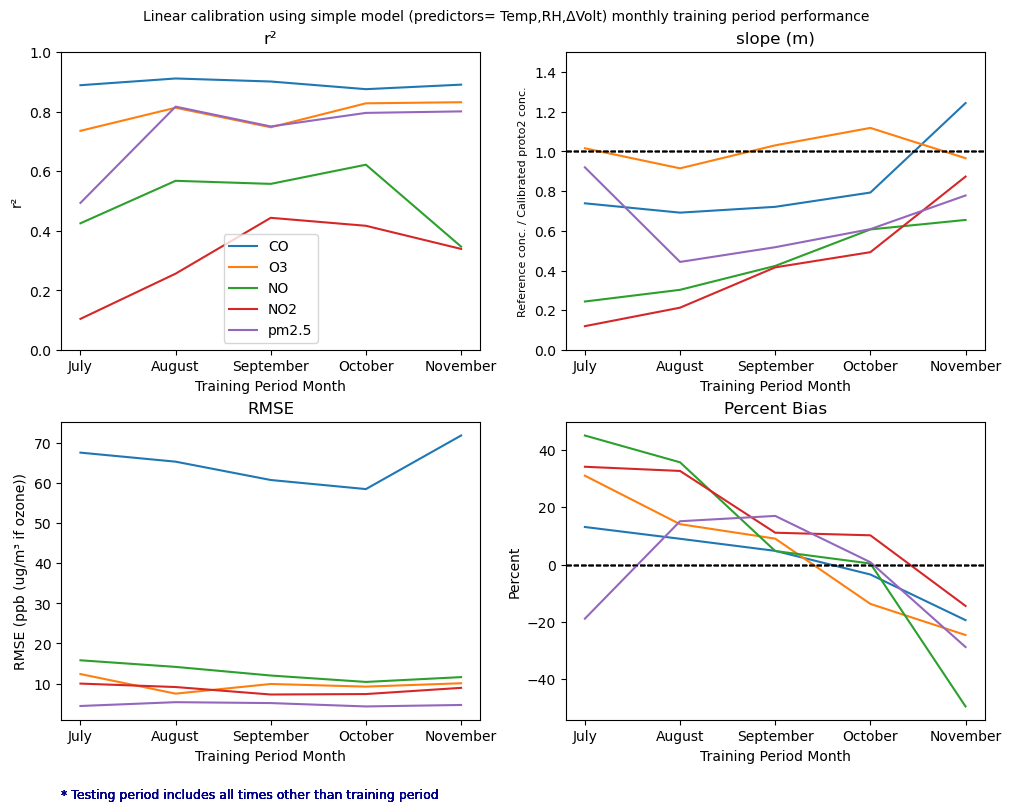

In [12]:
''' Monthly stat breakdown '''
fig = plt.subplots(figsize=(10,8), layout='constrained')
plt.suptitle('Linear calibration using simple model (predictors= Temp,RH,ΔVolt) monthly training period performance', fontsize=10)

r2_analysis = plt.subplot2grid((2, 2), (0, 0))
m_analysis = plt.subplot2grid((2, 2), (0, 1))
rmse_analysis = plt.subplot2grid((2, 2), (1, 0))
percentbias_analysis = plt.subplot2grid((2, 2), (1, 1))


var_id_2_name={42101:'CO',44201:'O3',42601:'NO',42602:'NO2',88101:'pm2.5'}
for var_id in [42101, 44201, 42601, 42602, 88101]:
    if var_id in [88101]:
        pltunit = 'ug/m³'
    else:
        pltunit = 'ppb'
            
    r2_analysis.plot(pollutant_stats_df_dict2[var_id]['Training Period'],pollutant_stats_df_dict2[var_id]['r²'], label=var_id_2_name[var_id])
    r2_analysis.set_ylim(0,1)
    r2_analysis.set_title('r²')
    r2_analysis.set_xlabel('Training Period Month')
    r2_analysis.set_ylabel('r²')
    r2_analysis.legend()

    
    m_analysis.plot(pollutant_stats_df_dict2[var_id]['Training Period'],pollutant_stats_df_dict2[var_id]['Slope (m)'], label=var_id_2_name[var_id])
    m_analysis.axhline(y = 1, color = 'black', linestyle = '--', linewidth=1) # indicate slope of 1 / 1:1 line
    m_analysis.set_ylim(0,1.5)
    m_analysis.set_title('slope (m)')
    m_analysis.set_xlabel('Training Period Month')
    m_analysis.set_ylabel('Reference conc. / Calibrated proto2 conc.', fontsize = 8)


    
    rmse_analysis.set_title('RMSE')
    rmse_analysis.plot(pollutant_stats_df_dict2[var_id]['Training Period'],pollutant_stats_df_dict2[var_id]['RMSE'], label=var_id_2_name[var_id])
    #rmse_analysis.legend(loc='upper center', bbox_to_anchor=(0,-0.15),
              #ncol=2, fancybox=True, shadow=True)
    rmse_analysis.set_xlabel('Training Period Month')
    rmse_analysis.set_ylabel('RMSE (ppb (ug/m³ if ozone))')
    rmse_analysis.text(0.45,-0.25, '* Testing period includes all times other than training period', horizontalalignment='center',
             verticalalignment='center', transform=rmse_analysis.transAxes, color='darkblue', fontsize=9) 

    
    percentbias_analysis.set_title('Percent Bias')
    percentbias_analysis.plot(pollutant_stats_df_dict2[var_id]['Training Period'],pollutant_stats_df_dict2[var_id]['Percent Bias'], label=var_id_2_name[var_id])
    percentbias_analysis.axhline(y = 0, color = 'black', linestyle = '--', linewidth=1) # indicate slope of 1 / 1:1 line
    percentbias_analysis.set_xlabel('Training Period Month')
    percentbias_analysis.set_ylabel('Percent')
    

figname = 'corrected_r2_slope_rmse_percentbias'
plt.savefig('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+figname+'.png',bbox_inches='tight',dpi=300)
#with open('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/'+figname+'_readme.txt', 'w') as f:
    #f.write('Model performance when data are trainined for one month and tested against the remaining months. \n Script used: monthly_reg_plots.ipynb')